# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [3]:
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib

## Задание 1 (1 балл)

Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [29]:
from collections import Counter
import math

def gini(x):
    return sum(
        count / len(x) * (1 - count / len(x))
        for _, count in Counter(x).items()
    )

def entropy(x):
    return sum(
        count / len(x) * math.log2(count / len(x))
        for _, count in Counter(x).items()
    )

def gain(left_y, right_y, criterion):
    y = pandas.concat([left_y, right_y])
    return len(y) * criterion(y) - len(left_y) * criterion(left_y) - len(right_y) * criterion(right_y)

# (gini(y_train), 
#     entropy(y_train), 
#     gain(y_train[::2], y_train[1::2], gini), 
#     gain(y_train[:len(y_train)//2], y_train[len(y_train)//2:], gini))

(0.0005433305765595464,
 -0.0064377663320349865,
 -1.9983695652173912,
 -1.9983695652173912)

## Задание 2 (1 балл)

Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [140]:
class DecisionTreeLeaf:
    def __init__(self, ys):
        self.y = ys.mode().__array__()[0]
        self.probs = {
            key: value / len(ys)
            for key, value in Counter(ys).items()
        }
        
    def predict_proba(self, x):
        return self.probs


class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right
        
    def predict_proba(self, x):
        idx = x[self.split_dim].index[0]
        if x[self.split_dim][idx] < self.split_value:
            return self.left.predict_proba(x)
        return self.right.predict_proba(x)

## Задание 3 (6 баллов)

Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [141]:
import sys

class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.root = None
        self._criterion = globals()[criterion]
        self._max_depth = max_depth
        self._min_samples_leaf = min_samples_leaf
    
    def fit(self, X, y):
        self.root = self._fit(pandas.merge(X, y, left_index=True, right_index=True), 1)
        
    def _fit(self, df, curr_depth):
        if curr_depth >= self._max_depth:
            return DecisionTreeLeaf(df["Expected"])
        
        print(f"Handling dataset with {len(df)} rows at depth {curr_depth}", file=sys.stderr)

        best_split_score = float("-inf")
        best_split_col = None
        best_split_value = None
        best_split_value_idx = None
        for col in df.columns:
            try:
                int(col)
            except:
                continue
            
            df = df.sort_values(by=col)
            prev_value = None
            for i, value in enumerate(df[col]):
                if value == prev_value:
                    continue
                prev_value = value
                    
                if (i < self._min_samples_leaf) or (len(df) - i < self._min_samples_leaf):
                    continue

                score = gain(df["Expected"][:i], df["Expected"][i:], self._criterion)
                if score > best_split_score:
                    best_split_score = score
                    best_split_col = col
                    best_split_value = value
                    best_split_value_idx = i

        if best_split_col is None:
            return DecisionTreeLeaf(df["Expected"])
        
        df = df.sort_values(by=best_split_col)
        return DecisionTreeNode(
            split_dim=best_split_col, 
            split_value=best_split_value,
            left=self._fit(df[:best_split_value_idx], curr_depth+1),
            right=self._fit(df[best_split_value_idx:], curr_depth+1),
        )
    
    def predict_proba(self, X):
        return [self.root.predict_proba(X[i:i+1]) for i in range(len(X))]
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [154]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, f"x[{tree_root.split_dim}] < {tree_root.split_value:g}",
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [155]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Задание 4 (2 балла)

Протестируйте решение на датасете spam.
Для этой задачи используйте данные x_spam_train и y_spam_train:
1. Выполните загрузку и предобработку файлов x_spam_train и y_spam_train.
2. Разбейте x_spam_train и y_spam_train на x_train, y_train, x_test и y_test для оценки точности работы алгоритма.
3. Посчитайте метрики `precision`, `recall`, `accuracy` для модели Decision Tree. Если необходимо, попробуйте разные наборы параметров для получения лучшего результата.
4. Сравните значения метрик с результатами модели kNN из предыдущего задания (можно использовать реализацию из библиотеки `sklearn`).
5. Ответьте на следующие вопросы:
    - Какой нужен препроцессинг данных для моделей?
    - Какая модель делает предсказания лучше?  Предположите, почему.

_Ваш ответ_

In [156]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

from sklearn.neighbors import KNeighborsClassifier

In [157]:
X_train, y_train = pandas.read_csv("x_spam_train.csv"), pandas.read_csv("y_spam_train.csv")
Xy_train = pandas.merge(X_train, y_train).sample(frac=1)
split = int(0.8 * len(Xy_train))
X_train, y_train = Xy_train[:split].drop(columns=["Expected"]), Xy_train["Expected"][:split]
X_test, y_test = Xy_train[split:].drop(columns=["Expected"]), Xy_train["Expected"][split:]
# X_test, y_test = pandas.read_csv("x_spam_test.csv"), None
pandas.merge(X_train, y_train, left_index=True, right_index=True)

,Id,0,1,2,3,4,5,6,7,8,...,48,49,50,51,52,53,54,55,56,Expected
1790,1790,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,...,0.000,0.735,0.000,0.000,0.000,0.000,2.450,11.0,49.0,0
1281,1281,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,...,0.000,0.299,0.000,0.000,0.000,0.199,2.465,28.0,106.0,1
2360,2360,0.00,0.0,0.00,0.0,0.00,0.23,0.0,0.00,0.0,...,0.000,0.000,0.000,0.000,0.069,0.000,2.216,44.0,215.0,0
1644,1644,0.00,0.0,0.87,0.0,0.00,0.14,0.0,0.00,0.0,...,0.019,0.019,0.019,0.000,0.000,0.000,2.174,35.0,461.0,0
2763,2763,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,...,0.000,0.186,0.186,0.000,0.000,0.000,3.862,28.0,112.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1550,1550,0.00,0.0,0.00,0.0,0.47,0.00,0.0,0.00,0.0,...,0.000,0.217,0.000,0.000,0.000,0.000,1.677,5.0,99.0,0
1683,1683,0.00,0.0,0.42,0.0,0.00,0.00,0.0,0.00,0.0,...,0.000,0.078,0.039,0.039,0.000,0.000,1.292,6.0,106.0,0
2030,2030,0.21,0.0,0.42,0.0,2.54,0.00,0.0,0.00,0.0,...,0.028,0.115,0.000,0.000,0.000,0.000,2.457,45.0,258.0,0
2290,2290,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,...,0.000,0.000,0.000,0.523,0.000,0.000,2.272,9.0,25.0,0


In [158]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train, y_train)

Handling dataset with 2944 rows at depth 1
Handling dataset with 2225 rows at depth 2
Handling dataset with 2015 rows at depth 3
Handling dataset with 1773 rows at depth 4
Handling dataset with 242 rows at depth 4
Handling dataset with 210 rows at depth 3
Handling dataset with 52 rows at depth 4
Handling dataset with 158 rows at depth 4
Handling dataset with 719 rows at depth 2
Handling dataset with 669 rows at depth 3
Handling dataset with 30 rows at depth 4
Handling dataset with 639 rows at depth 4
Handling dataset with 50 rows at depth 3


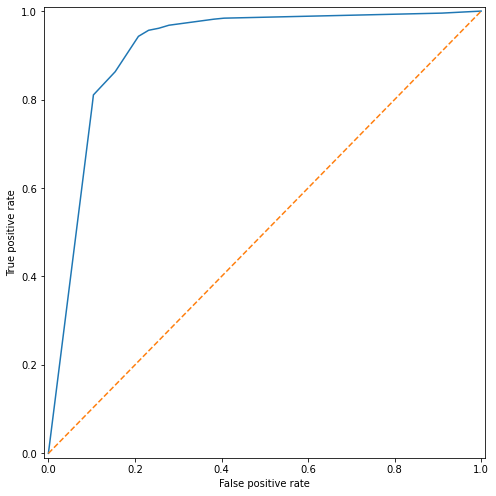

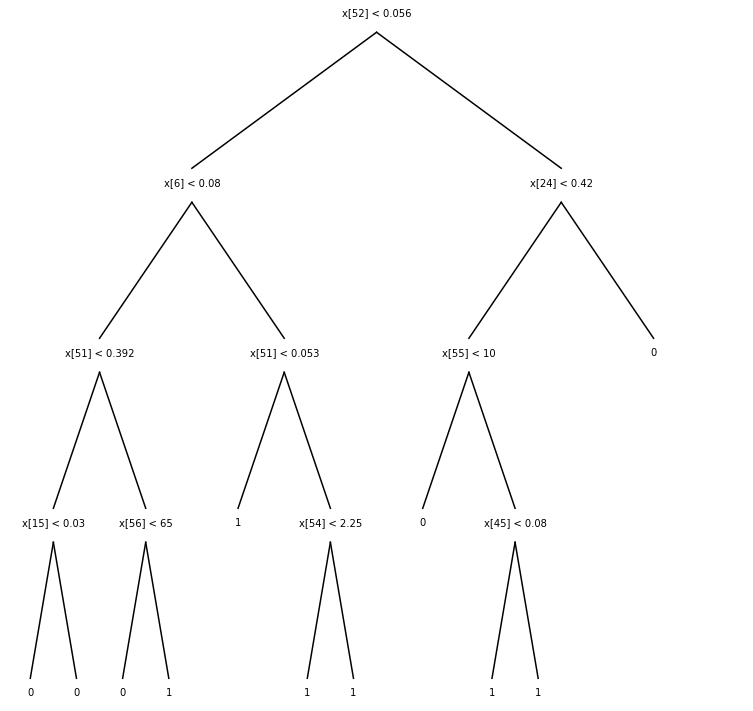

In [159]:
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

1. Обучите модель на всех данных из x_spam_train и y_spam_train.
2. Сделайте submit своего решения и получите значение f1_score не менее 0.6

In [160]:
X_contest = pandas.read_csv("x_spam_test.csv")
submission = pandas.DataFrame(columns = ["Id", "Expected"])
submission["Id"] = X_contest["Id"]
submission["Expected"] = tree.predict(X_contest)
submission.to_csv('submission.csv', index=False)